# Comparison between recommendations of pipeplines

**Update 27/Nov/2020:** kernel normalisation over all 4138 unique sequences. Adjust parameters [centering_flag, unit_norm_flag] for kernel normalisation. 

**Update 15/Nov/2020:** recommend based on round 0 + 1 data. This notebook shows the recommendations from different pipelines by scatter plotting the ucb scores/ucb ranks of the union set of top n recommendations from different pipelines.

Particularly, this notebook shows the comparison betweeen recommendations from different hyperparameters (alpha, sigma_0).

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *
import codes.plot_format as plotFormat

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

known_df = pd.read_csv(Path)
known_df.head()

,idx,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Replicates,Plate,Round,Rep7,Rep8,Rep9,RBS6,Pred Mean,Pred Std,Pred UCB
0,648.0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
1,4096.0,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
2,4097.0,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
3,4098.0,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
4,4099.0,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN


In [3]:
run_new_experiment = False


if run_new_experiment:
    for alpha in [2]:
        for sigma_0 in [1]:
            for beta in [2]:
                for centering_flag in [True,False]:
                    for unit_norm_flag in [True,False]:
                        top_n = Top_n_ucb(known_df, kernel_name='WD_Kernel_Shift', l=6, s=1, sigma_0 = sigma_0,
                                        embedding='label', alpha=alpha, rec_size=None, beta=beta,
                                        centering_flag = centering_flag, unit_norm_flag = unit_norm_flag)

                        top_n_rec_df = top_n.run_experiment()

                        # top_n_rec_df['index'] = top_n_rec_df['level_0']
                        # top_n_rec_df = top_n_rec_df.drop(columns = ['level_0'])

                        with pd.ExcelWriter('all_ucb_pred.xlsx', engine="openpyxl", mode='a') as writer:  
                            top_n_rec_df.to_excel(writer, sheet_name=plotFormat.valid_name('train_samples_alpha' + str(alpha) + '_sigma0_' + str(sigma_0) + '_beta_' + str(beta) + '_cen' + str(centering_flag) + '_uninorm' + str(unit_norm_flag)))

In [4]:
type(True)

bool

In [5]:
if run_new_experiment:

    top_n = Top_n_ucb(known_df, kernel_name='RBF', embedding='onehot', alpha=2, rec_size=None, beta=2)

    top_n_rec_df = top_n.run_experiment()
    # top_n_rec_df['index'] = top_n_rec_df['level_0']
    # top_n_rec_df = top_n_rec_df.drop(columns = ['level_0'])

    with pd.ExcelWriter('all_ucb_pred_kernelAdjust.xlsx', engine="openpyxl", mode='a') as writer:  
        top_n_rec_df.to_excel(writer, sheet_name=plotFormat.valid_name('train_samples_RBF_alpha' + str(alpha) + '_beta_' + str(beta)))

## Read prediction data; Plot ucb scores

Take two prediction list from different pipelines, take the union set of top n ucb scores, and scatter plot 
- the ucb scores for both pipeline predictions. x and y axis represents the predicted ucb scores from each pipeline, the same point represents the same sequence. 
- the rank of ucb scores (top UCB value is rank 1, the second rank 2, etc.) for both pipeline predictions. The units on the axis should be ranks (the plots will now be backwards, with the best items near the origin).



In [6]:
def scatterplot_union_ucb_scores(df1, df2, df1_name, df2_name, rec_size = 90):
    """For two rec df from different pipelines,
    take the union set and scatter plot ucb scores.
    
    Input dataframe has at least two columns: index, ucb
    """
    union_rec_index = list(set(df1[:rec_size]['index']).union(set(df2[:rec_size]['index'])))
    print('union set size: ', len(union_rec_index))
    new_df1 = df1.loc[df1['index'].isin(union_rec_index)][['index', 'ucb']]
    new_df2 = df2.loc[df2['index'].isin(union_rec_index)][['index', 'ucb']]
    new_df1['rank'] = new_df1.index + 1
    new_df2['rank'] = new_df2.index + 1
    
    merge_df = new_df1.merge(new_df2, on = 'index')
    merge_df = merge_df.rename(columns = {'ucb_x': 'ucb_' + str(df1_name), 'ucb_y': 'ucb_' + str(df2_name),
                                         'rank_x': 'rank_' + str(df1_name), 'rank_y': 'rank_' + str(df2_name)})
    
    fig,a = plt.subplots(1, 2, figsize = (12,4))
    sns.scatterplot(x = 'ucb_'  + str(df1_name), y = 'ucb_' + str(df2_name), data = merge_df, ax = a[0])
    
    a[0].set_title('ucb scatter')
    sns.scatterplot(x = 'rank_' + str(df1_name), y = 'rank_' + str(df2_name), data = merge_df, ax = a[1])
    a[1].set_title('rank scatter')
    #a[1].set_xlim(-10,300)
    #a[1].set_ylim(-10,300)

In [7]:
sheet_to_df_map = pd.read_excel('all_ucb_pred_kernelAdjust.xlsx', sheet_name=None)
sheet_to_df_map.keys()

dict_keys(['train samples alpha2 sigma0 1 beta 2 cenTrue uninormTrue', 'train samples alpha2 sigma0 1 beta 2 cenTrue uninormFalse', 'train samples alpha2 sigma0 1 beta 2 cenFalse uninormTrue', 'train samples alpha2 sigma0 1 beta 2 cenFalse uninormFalse', 'train samples RBF alpha2 beta 2'])

# Kernle Normalisation?

union set size:  126


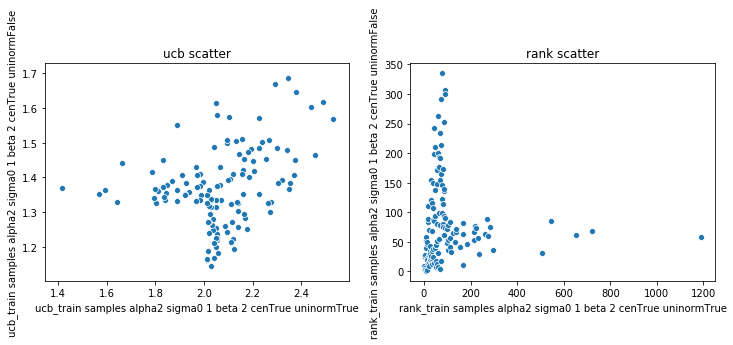

In [8]:

scatterplot_union_ucb_scores(list(sheet_to_df_map.values())[0],list(sheet_to_df_map.values())[1], 
                            list(sheet_to_df_map.keys())[0],list(sheet_to_df_map.keys())[1])

union set size:  92


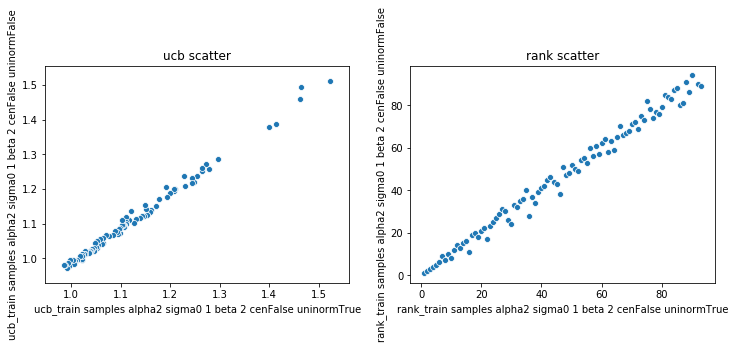

In [9]:

scatterplot_union_ucb_scores(list(sheet_to_df_map.values())[2],list(sheet_to_df_map.values())[3], 
                            list(sheet_to_df_map.keys())[2],list(sheet_to_df_map.keys())[3])

union set size:  154


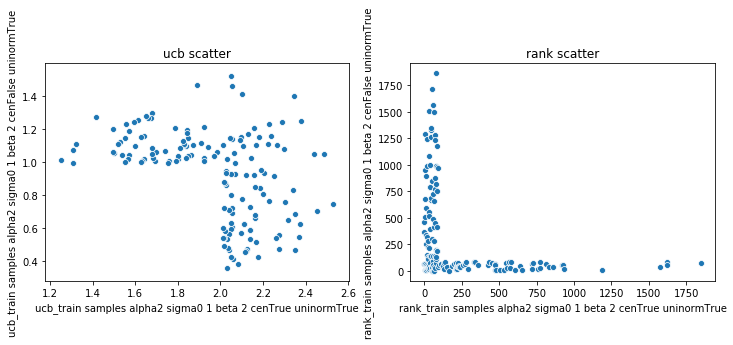

In [10]:

scatterplot_union_ucb_scores(list(sheet_to_df_map.values())[0],list(sheet_to_df_map.values())[2], 
                            list(sheet_to_df_map.keys())[0],list(sheet_to_df_map.keys())[2])

union set size:  131


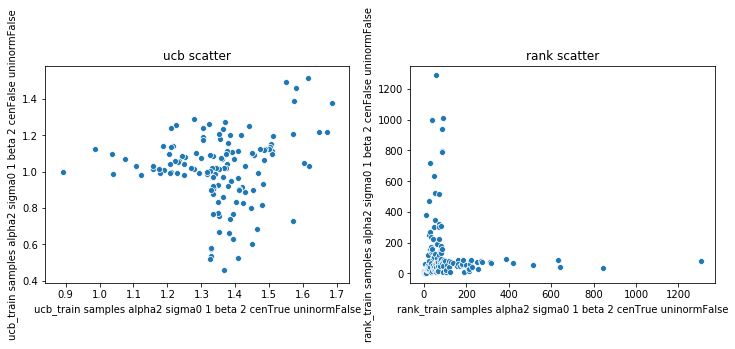

In [11]:

scatterplot_union_ucb_scores(list(sheet_to_df_map.values())[1],list(sheet_to_df_map.values())[3], 
                            list(sheet_to_df_map.keys())[1],list(sheet_to_df_map.keys())[3])

# RBF?

union set size:  167


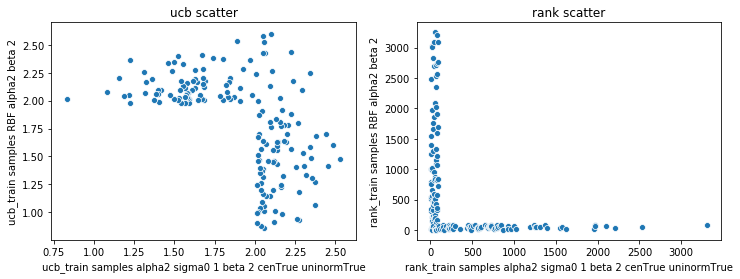

In [12]:

scatterplot_union_ucb_scores(list(sheet_to_df_map.values())[0],list(sheet_to_df_map.values())[-1], 
                            list(sheet_to_df_map.keys())[0],list(sheet_to_df_map.keys())[-1])

union set size:  151


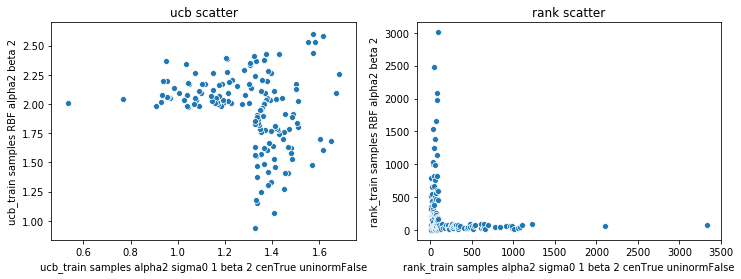

In [13]:

scatterplot_union_ucb_scores(list(sheet_to_df_map.values())[1],list(sheet_to_df_map.values())[-1], 
                            list(sheet_to_df_map.keys())[1],list(sheet_to_df_map.keys())[-1])

union set size:  130


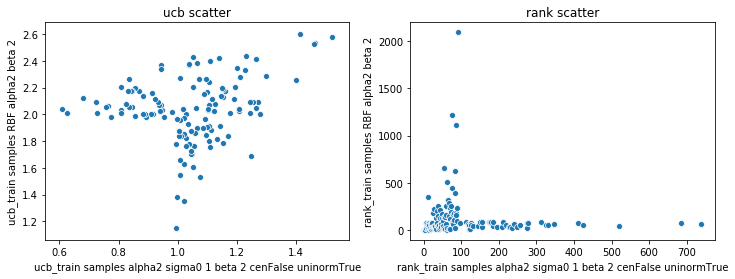

In [14]:

scatterplot_union_ucb_scores(list(sheet_to_df_map.values())[2],list(sheet_to_df_map.values())[-1], 
                            list(sheet_to_df_map.keys())[2],list(sheet_to_df_map.keys())[-1])

union set size:  130


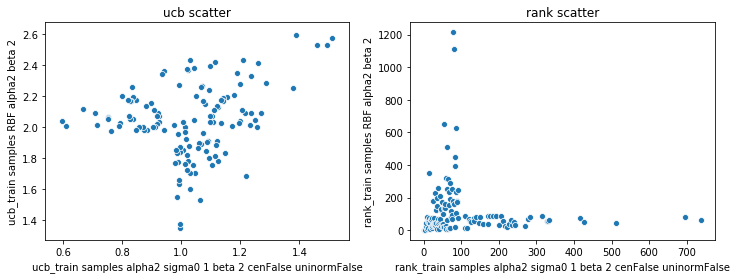

In [15]:

scatterplot_union_ucb_scores(list(sheet_to_df_map.values())[3],list(sheet_to_df_map.values())[-1], 
                            list(sheet_to_df_map.keys())[3],list(sheet_to_df_map.keys())[-1])

In [16]:
pd.set_option('mode.chained_assignment', None) # Turn off warnings

def scatterplot_for_diff_beta(df, name1, name2, rec_size = 90):
    """For the rec df pred mean and std, generating ucb with different beta 
    take the union set and scatter plot ucb scores.
    
    Input dataframe has at least two columns: index, ucb
    """
    df1 = df[['index', 'ucb_' + str(name1)]].copy()
    df1 = df1.sort_values(by = 'ucb_' + str(name1), ascending = False).reset_index()
    df2 = df[['index', 'ucb_' + str(name2)]].copy()
    df2 = df2.sort_values(by = 'ucb_' + str(name2), ascending = False).reset_index()
    
    union_rec_index = list(set(df1[:rec_size]['index']).union(set(df2[:rec_size]['index'])))
    print('union set size: ', len(union_rec_index))
    new_df1 = df1.loc[df1['index'].isin(union_rec_index)]
    new_df2 = df2.loc[df2['index'].isin(union_rec_index)]
    new_df1['rank'] = new_df1.index + 1
    new_df2['rank'] = new_df2.index + 1
    
    merge_df = new_df1.merge(new_df2, on = 'index')
    merge_df = merge_df.rename(columns = {'ucb_x': 'ucb_' + str(name1), 'ucb_y': 'ucb_' + str(name2),
                                         'rank_x': 'rank_' + str(name1), 'rank_y': 'rank_' + str(name2)})
#     print(merge_df)
    fig,a = plt.subplots(1, 2, figsize = (12,4))
    sns.scatterplot(x = 'ucb_'  + str(name1), y = 'ucb_' + str(name2), data = merge_df, ax = a[0])   
    a[0].set_title('ucb scatter ' + str(name1) + ' vs ' + str(name2))
    sns.scatterplot(x = 'rank_' + str(name1), y = 'rank_' + str(name2), data = merge_df, ax = a[1])
    a[1].set_title('rank scatter' + str(name1) + ' vs ' + str(name2))
    #a[1].set_xlim(-10,300)
    #a[1].set_ylim(-10,300)

## Conclusion of pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Kernel: codes/kernels_for_GPK.py
    - weighted degree kernel with shift
    - normalisation: centering; unit variance; normalisation over the whole (train + test) kernel
    - l = 6 (maximum substring length)
    - s = 1 (shift)
    - sigma0 = 1 (signal std)
- Regression: codes/regression.py
    - Gaussian Process Regression
    - train on samples (multi-label) from first round result, i.e. train shape:  (1055, 20)
    - predict on all design space (4 * 6) except known sequences, i.e. test shape:  (3961, 20)
    - alpha = 2
- Recommendation: codes/batch_ucb.py
    - batch UCB (GP-BUCB)
    - beta = 2
    - recommendation size = 90